# Classification

## MNIST

In [1]:
# Load MNIST dataset

from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

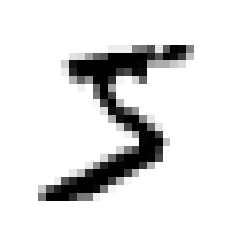

In [3]:
# Look at one example
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

In [6]:
# Create train and test sets

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [7]:
# Let's simplify the problem for now and only try to identify one digit
# This detector will be an example of a binary classifier
# Let's create the target vectors for this classification task

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [8]:
# Let's create a Stochastic Gradient Descent classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

/Users/matthieubritoantunes/ml/env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [16]:
# Implementing Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [17]:
# Let's evaluate the SGDClassifier using K-fold cross-validation

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [19]:
# How does this accuracy compares with a dumb classifier 
# that just classifies every single image in the "not-5" class ?

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# Above 90 % accuracy (ratio of correct predictions) on all cross-validation folds ?
# This is simply because only about 10 % of the images are 5s, so if you always guess that an image is not 5
# You will be right about 90 % of the time
# Accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [20]:
# Let's make predictions to compute the confusion matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
# Compute confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [23]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311


In [24]:
# Combine precision and recall and get F1-score

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision / Recall Tradeoff

In [31]:
# Let's return a score for each instance instead of a prediction
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

# Let's set an artificial classification threshold to 0
threshold = 0
print("Threshold:", threshold)
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# Let's now raise the threshold to 8000
threshold = 8000
print("Threshold:", threshold)
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
Threshold: 0
[ True]
Threshold: 8000
[False]


/Users/matthieubritoantunes/ml/env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [32]:
# Deciding which threshold to use
# Get scores of all instances in the training set

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [33]:
# Compute precision and recall for all possible thresholds

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

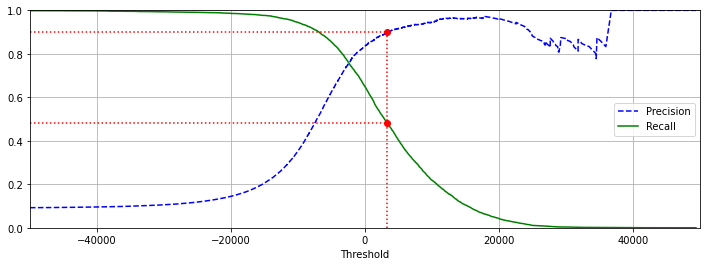

In [42]:
# Plot precision and recall as functions of the threshold

import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right")
    plt.xlabel("Threshold")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions>=0.9)]
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

plt.figure(figsize=(12,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [.9, .9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

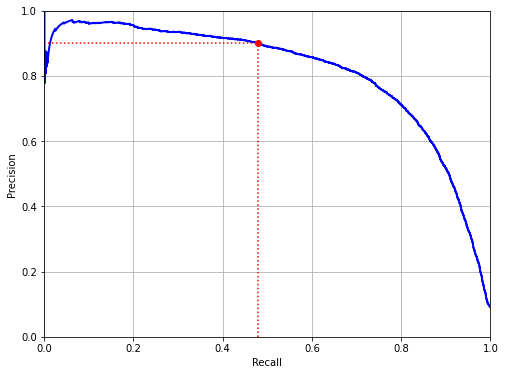

In [38]:
# Plot precision as a function of the recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., .9], "r:")
plt.plot([0.0, recall_90_precision], [.9, .9], "r:")
plt.plot([recall_90_precision], [.9], "ro")
plt.show()

In [43]:
# Let's suppose we decide to aim for 90 % precision.
# Let's search for the lowest threshold that gives at least 90% precision

threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

In [44]:
# To make predictions (on the training set for now), instead of calling the classifier's predict() method, let's use this threshold

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [55]:
# Let's check these prediction's precision and recall

print("Precision with 90% precision threshold: {:.2f}".format(precision_score(y_train_5, y_train_pred_90)))
print("Recall with 90% precision threshold: {:.2f}".format(recall_score(y_train_5, y_train_pred_90)))

Precision with 90% precision threshold: 0.90
Recall with 90% precision threshold: 0.48


### The ROC Curve

In [56]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

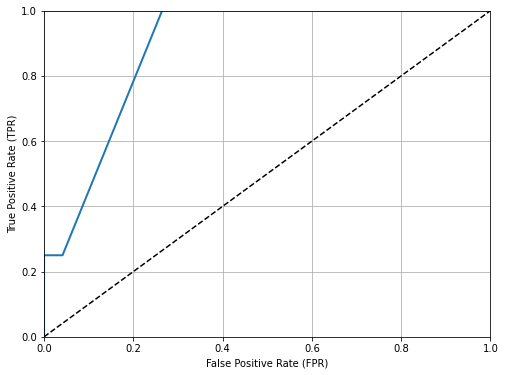

In [80]:
def plot_roc_curve(fpr, tpr, label="None"):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.grid(True)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr>=recall_90_precision)]
#plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
#plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
#plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [73]:
import pandas as pd
automl = pd.read_csv("automl-sekurit-v1-eval.csv")

fpr = automl["fpr"].to_numpy()
tpr = automl["tpr"].to_numpy()
precisions = automl["precision"].to_numpy()
recalls = automl["recall"].to_numpy()

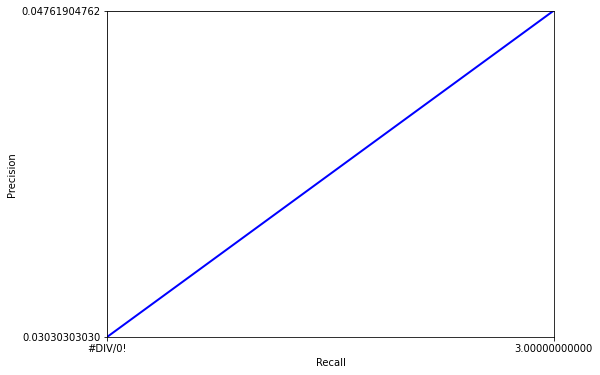

In [76]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)

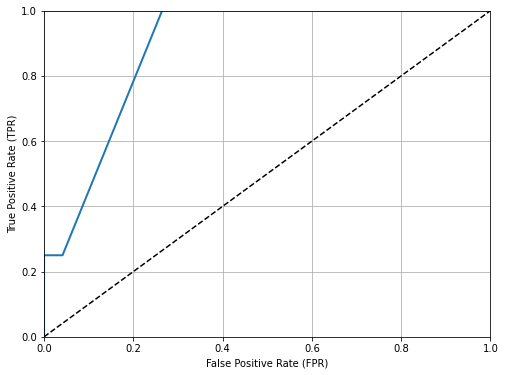

In [78]:
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
#fpr_90 = fpr[np.argmax(tpr>=recall_90_precision)]
#plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
#plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
#plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()